In [3]:
!git branch
!git checkout TFT
!git branch

* TFT
  main
M	TFT.ipynb

Already on 'TFT'



Your branch is up to date with 'origin/TFT'.
* TFT
  main


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from torch.nn import MSELoss
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# Weather Dataset

In [6]:
electricity_consumption = pd.read_csv("./WeatherPreprocessing/WeatherBusinessResidential.csv")
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
0,2010-01-01,41.90,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000
1,2010-02-01,34.80,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792
2,2010-03-01,7.60,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270
3,2010-04-01,48.40,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576
4,2010-05-01,197.50,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480
...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,43.80,20.35,17.85,3.70,3.5,1.30,2024.0,2.0,574.002,311.724
170,2024-03-01,55.65,17.90,15.60,4.10,10.5,2.10,2024.0,3.0,581.184,337.730
171,2024-04-01,81.95,16.95,15.95,3.65,8.0,1.80,2024.0,4.0,555.174,348.859
172,2024-05-01,115.75,13.35,12.80,3.75,11.5,1.75,2024.0,5.0,593.551,452.473


In [7]:
electricity_consumption['Date'] = pd.to_datetime(electricity_consumption['Date'], format='%Y-%m-%d')
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
0,2010-01-01,41.90,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000
1,2010-02-01,34.80,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792
2,2010-03-01,7.60,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270
3,2010-04-01,48.40,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576
4,2010-05-01,197.50,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480
...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,43.80,20.35,17.85,3.70,3.5,1.30,2024.0,2.0,574.002,311.724
170,2024-03-01,55.65,17.90,15.60,4.10,10.5,2.10,2024.0,3.0,581.184,337.730
171,2024-04-01,81.95,16.95,15.95,3.65,8.0,1.80,2024.0,4.0,555.174,348.859
172,2024-05-01,115.75,13.35,12.80,3.75,11.5,1.75,2024.0,5.0,593.551,452.473


<Axes: xlabel='Date'>

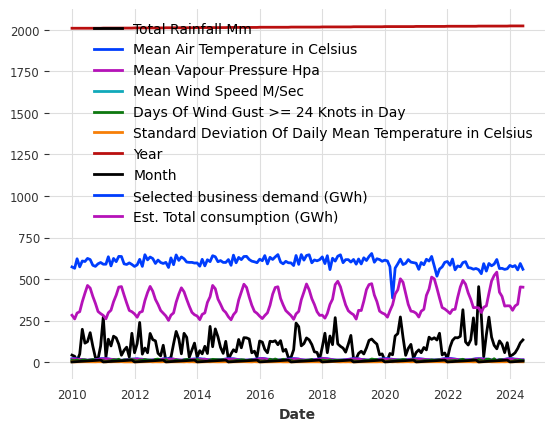

In [8]:
# Convert dataframe to Timeseries
ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )

ts.plot()

<Axes: xlabel='Date'>

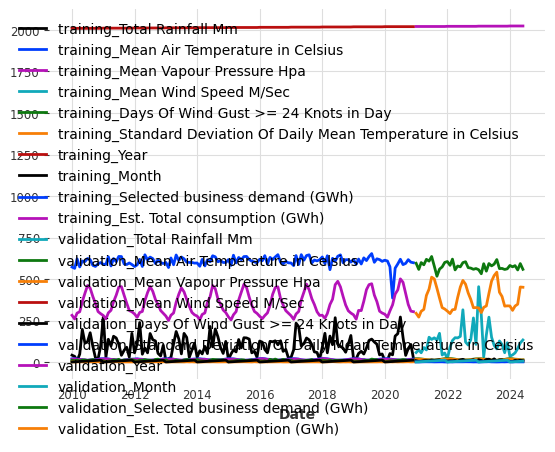

In [9]:
# training and validation split
training_cutoff = pd.Timestamp('2021-01-01')
train, val = ts.split_before(training_cutoff)
train.plot(label='training')
val.plot(label='validation')

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
transformer_target = Scaler(scaler)

# extract the goal value
train_target_og = train['Est. Total consumption (GWh)']
val_target_og = val['Est. Total consumption (GWh)']
train_target = transformer_target.fit_transform(train_target_og)
val_target = transformer_target.transform(val_target_og)

train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

#split past covariates
train_past_cov_df = train_transformed.pd_dataframe()[['Days Of Wind Gust >= 24 Knots in Day', 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa', 'Total Rainfall Mm']]
val_past_cov_df = val_transformed.pd_dataframe()[['Days Of Wind Gust >= 24 Knots in Day', 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa', 'Total Rainfall Mm']]

train_past_cov_df = train_past_cov_df.apply(lambda col: col.fillna(col.mean()))
val_past_cov_df = val_past_cov_df.apply(lambda col: col.fillna(col.mean()))

# convert DataFrame into TimeSeries
train_past_cov = TimeSeries.from_dataframe(train_past_cov_df)
val_past_cov = TimeSeries.from_dataframe(val_past_cov_df)

In [12]:
train_transformed.pd_dataframe()

component,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
Date,,,,,,,,,,
2010-01-01,0.129875,0.797357,0.653061,0.611111,0.545455,0.342105,0.0,0.000000,0.698370,0.123807
2010-02-01,0.102991,0.911894,0.887755,0.407407,0.363636,0.078947,0.0,0.090909,0.668095,0.035130
2010-03-01,0.000000,0.731278,0.576531,0.666667,0.636364,0.210526,0.0,0.181818,0.881573,0.176794
2010-04-01,0.154487,0.533040,0.515306,0.222222,0.303030,0.184211,0.0,0.272727,0.699643,0.209960
2010-05-01,0.719046,0.317181,0.346939,0.370370,0.636364,0.473684,0.0,0.363636,0.831567,0.449157
...,...,...,...,...,...,...,...,...,...,...
2020-08-01,0.534267,0.154185,0.158163,0.500000,0.818182,0.263158,1.0,0.636364,0.751438,0.917249
2020-09-01,0.125331,0.220264,0.112245,0.648148,0.727273,0.526316,1.0,0.727273,0.779914,0.648959
2020-10-01,0.282469,0.440529,0.357143,0.333333,0.181818,0.763158,1.0,0.818182,0.863608,0.384243


In [13]:
print(f"Train past covariates start: {train_past_cov.start_time()}")
print(f"Train past covariates end: {train_past_cov.end_time()}")

print(f"Validation past covariates start: {val_past_cov.start_time()}")
print(f"Validation past covariates end: {val_past_cov.end_time()}")

Train past covariates start: 2010-01-01 00:00:00
Train past covariates end: 2020-12-01 00:00:00
Validation past covariates start: 2021-01-01 00:00:00
Validation past covariates end: 2024-06-01 00:00:00


In [19]:
input_chunk_length = 36
forecast_horizon = 48

my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=3,
    dropout=0.005,
    batch_size=30,
    n_epochs=300,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month', 'day']},  
        'datetime_attribute': {'future': ['dayofweek', 'month', 'year']}, # instead of future covariate
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=42,
)

In [20]:
my_model.fit(train_target, past_covariates = train_past_cov, verbose=True)

Training: |                                                                                      | 0/? [00:00<…

TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=3, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.005, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=48, batch_size=30, n_epochs=300, add_encoders={'cyclic': {'past': ['month', 'day']}, 'datetime_attribute': {'future': ['dayofweek', 'month', 'year']}}, random_state=42)

In [21]:
from darts.metrics import mape, mae, rmse

Predicting: |                                                                                    | 0/? [00:00<…

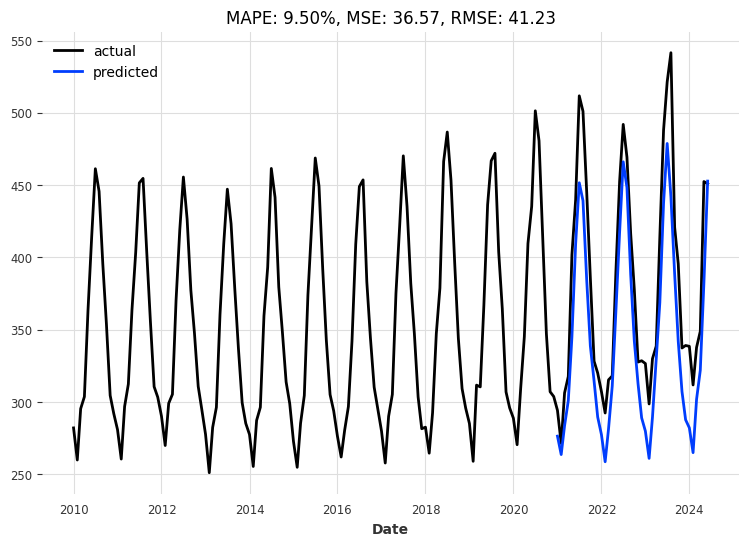

In [22]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=1)
    figsize = (9, 6)
    
   # just extract the goal column
    actual_series_target = actual_series['Est. Total consumption (GWh)']  

    # inverse transform
    actual_series_inv = transformer_target.inverse_transform(actual_series_target)
    pred_series_inv = transformer_target.inverse_transform(pred_series)  
    
    # get metric
    mape_val = mape(val_series, pred_series_inv)
    mae_val = mae(val_series, pred_series_inv)
    rmse_val = rmse(val_series, pred_series_inv) 
    
    # plot
    plt.figure(figsize=figsize)
    actual_series_inv.plot(label="actual")
    pred_series_inv.plot(label="predicted")

    # title
    plt.title("MAPE: {:.2f}%, MSE: {:.2f}, RMSE: {:.2f}".format(mape_val, mae_val, rmse_val))
    plt.legend()

eval_model(my_model, 42, series_transformed, val_target_og)

Predicting: |                                                                                    | 0/? [00:00<…

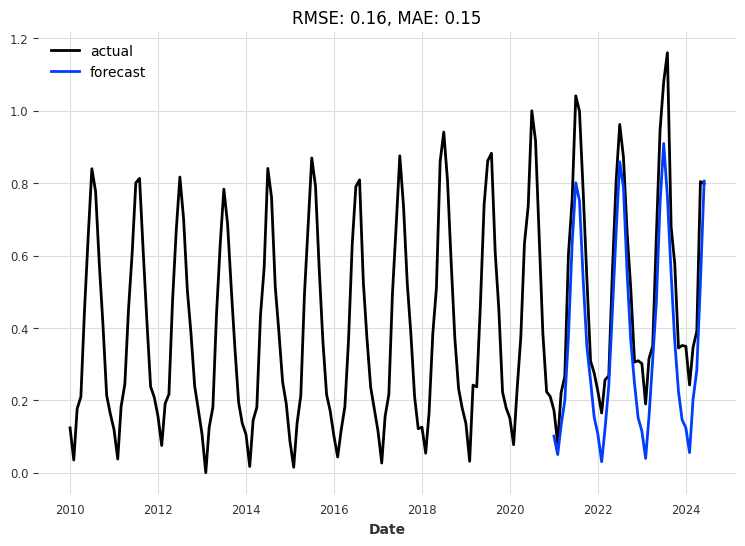

In [23]:
def eval_model(model):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(9, 6))
    series_transformed['Est. Total consumption (GWh)'].plot(label="actual")
    pred_series['Est. Total consumption (GWh)'].plot(label="forecast")
    plt.title("RMSE: {:.2f}, MAE: {:.2f}".format(rmse(val_target, pred_series), mae(val_target, pred_series)))
    plt.legend()
    return pred_series

pred_series_transformed = eval_model(my_model)

# Backtesting

In [51]:
series_target = series_transformed['Est. Total consumption (GWh)']

backtest_series = my_model.historical_forecasts(
    series_target,               
    past_covariates=train_past_cov,    
    start=train.end_time() + train.freq,  
    num_samples=1,                     
    forecast_horizon=24,  
    stride=1,            
    last_points_only=False,            
    retrain=True,                      
    verbose=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

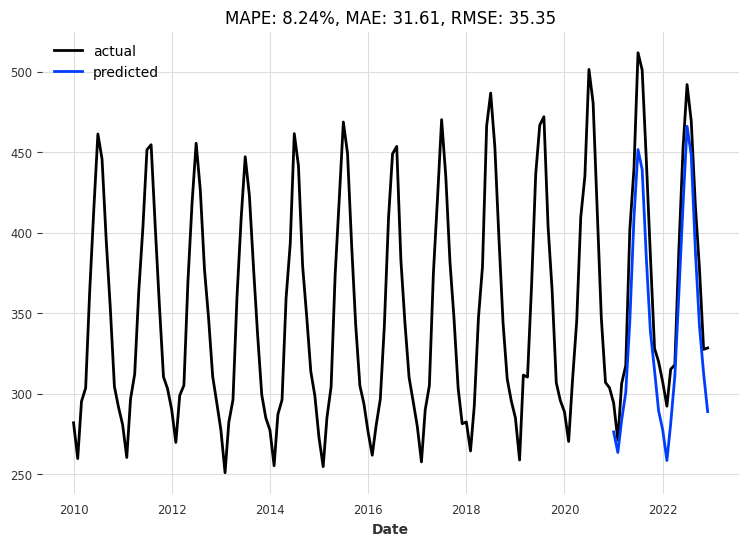

In [52]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    
    actual_series_target = actual_series['Est. Total consumption (GWh)']  
    # print("Actual series length:", len(actual_series_target))
    
    actual_series_inv = transformer.inverse_transform(actual_series_target[: backtest_series.end_time()])
    backtest_series_inv = transformer.inverse_transform(backtest_series)  

    # print("Actual Inverse First 5:", actual_series_inv[:5])
    # print("Predicted Inverse First 5:", backtest_series_inv[:5])
    
    mape_val = mape(actual_series_inv, backtest_series_inv)
    mae_val = mae(actual_series_inv, backtest_series_inv)
    rmse_val = rmse(actual_series_inv, backtest_series_inv)
    
    plt.figure(figsize=(9, 6))
    actual_series_inv.plot(label="actual")
    backtest_series_inv.plot(label="predicted")

    plt.title("MAPE: {:.2f}%, MAE: {:.2f}, RMSE: {:.2f}".format(mape_val, mae_val, rmse_val))
    plt.legend()
    plt.show()

eval_backtest(
    backtest_series=concatenate(backtest_series),  
    actual_series=series_transformed,             
    horizon=forecast_horizon,                    
    start=training_cutoff,                      
    transformer=transformer_target          
)